# Environment - Setup
This Jupyter playbook uses the work from Mark Harris about [optimization in parallel reduction with CUDA](https://developer.download.nvidia.com/assets/cuda/files/reduction.pdf)to describe a quick and straightforward introduction to Kernel optimization using Google Colab, demonstrates the optimization steps, describes the way to collect Nsys and Ncu profiles (Nvidia), compares times with each kernel version, and finally, contrasts all of them with Helion based on Triton.


In [5]:
!pip install pycuda
!pip install numpy
!pip install matplotlib
!pip install nvtx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.9 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=dbb051487d63d20a14dcd017cd1886a927b504c644d18636e696bedb77dc525c
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


In [6]:
import subprocess
def get_gpu_info():
 try:
    output = subprocess.check_output(
     ["nvidia-smi"],
     universal_newlines=True
     )
    print("GPU Information:")
    print(output)
 except:
    print("No NVIDIA GPU detected or nvidia-smi not installed")

get_gpu_info()

GPU Information:
Mon Nov 10 21:19:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------------

In [7]:
import pycuda.autoinit
import pycuda.driver as cuda
import numpy as np
def verify_pycuda_setup():
    try:
        # Get device properties
        print(f"CUDA version: {cuda.get_version()}")
        print(f"Device name: {pycuda.autoinit.device.name()}")
        print(f"Compute capability: {pycuda.autoinit.device.compute_capability()}")
        print(f"Total memory: {pycuda.autoinit.device.total_memory() // (1024*1024)} MB")

        device=cuda.Device(0)
        atts = device.get_attributes()
        print(f"Max Block DIM.X: {atts[cuda.device_attribute.MAX_BLOCK_DIM_X]}")
        print(f"Max Block DIM.Y: {atts[cuda.device_attribute.MAX_BLOCK_DIM_Y]}")
        print(f"Max Block DIM.Z: {atts[cuda.device_attribute.MAX_BLOCK_DIM_Z]}")
        print(f"Max Threads per Block: {atts[cuda.device_attribute.MAX_THREADS_PER_BLOCK]}")
        print(f"WARP (Max Concurrent): {atts[cuda.device_attribute.WARP_SIZE]}")
        print(f"Max GRID DIM.X: {atts[cuda.device_attribute.MAX_GRID_DIM_X]}")
        print(f"Max GRID DIM.Y: {atts[cuda.device_attribute.MAX_GRID_DIM_Y]}")

        # Try a simple operation
        a = np.random.randn(100).astype(np.float32)
        a_gpu = cuda.mem_alloc(a.nbytes)
        cuda.memcpy_htod(a_gpu, a)
        # Release allocated mem
        a_gpu.free()

        print("\nSuccessfully allocated and copied memory to GPU!")
        print("PyCUDA is working correctly!")
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Please check your installation.")

verify_pycuda_setup()


CUDA version: (12, 5, 0)
Device name: Tesla T4
Compute capability: (7, 5)
Total memory: 15095 MB
Max Block DIM.X: 1024
Max Block DIM.Y: 1024
Max Block DIM.Z: 64
Max Threads per Block: 1024
WARP (Max Concurrent): 32
Max GRID DIM.X: 2147483647
Max GRID DIM.Y: 65535

Successfully allocated and copied memory to GPU!
PyCUDA is working correctly!


In [8]:
# Installing nsight-systems-2022.4.1 & nsight-compute-2022.1.1
!apt-get update -y && \
     DEBIAN_FRONTEND=noninteractive apt-get install -y --no-install-recommends \
         apt-transport-https \
         ca-certificates \
         gnupg \
         wget && \
     rm -rf /var/lib/apt/lists/*
!wget -qO - https://developer.download.nvidia.com/devtools/repos/ubuntu2004/amd64/nvidia.pub | apt-key add - && \
     echo "deb https://developer.download.nvidia.com/devtools/repos/ubuntu2004/amd64/ /" >> /etc/apt/sources.list.d/nsight.list && \
     apt-get update -y && \
     DEBIAN_FRONTEND=noninteractive apt-get install -y --no-install-recommends \
         nsight-systems-2023.3.1 nsight-compute-2025.2.1 && \
     rm -rf /var/lib/apt/lists/*

# setting environment variable path
import os
os.environ["PATH"] = "/usr/local/bin" + os.pathsep + os.getenv("PATH")

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,125 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,825 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports I

In [9]:
!nsys --version
!echo "---"
!ncu --version

NVIDIA Nsight Systems version 2023.3.1.92-233133147223v0
---
NVIDIA (R) Nsight Compute Command Line Profiler
Copyright (c) 2018-2025 NVIDIA Corporation
Version 2025.2.1.0 (build 35987062) (public-release)


# Optimization Strategies


## 0. Global Memory

- Global Memory without shared mem
- Strided Memory Access (Fixed offset between each access)


In [10]:
#Data
N = 10 ** 6
input_data = np.random.randn(N).astype(np.float32)
results = []

In [11]:
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import numpy as np
import time
import nvtx

@nvtx.annotate("reduction_sum_global(input_data,show:bool=False)", color="purple")
def reduction_sum_global(input_data,show:bool=False):
  reduction_global = SourceModule("""
  __global__ void reduce(float *g_idata, float *g_odata)
  {
    int tid = threadIdx.x;
    int gid = threadIdx.x + blockDim.x*blockIdx.x;

    //reduction method from global memory
    for(unsigned int s=1; s < blockDim.x; s*=2)
    {
      if(tid % (2*s) == 0)
      {
        g_idata[gid] += g_idata[gid + s];
      }
      __syncthreads();
    }

    if (tid==0) g_odata[blockIdx.x] = g_idata[gid];
  }
  """)

  block_size = 256 #Threads per block
  grid_size = (N + block_size -1) // block_size
  with nvtx.annotate("mem allocation", color="purple"):
    start=time.time()
    ginput = cuda.mem_alloc(input_data.nbytes)
    goutput = cuda.mem_alloc(grid_size*np.dtype(np.float32).itemsize)
    end=time.time()
  res_memalloc_time_sec = end - start
  res_memalloc_bytes = (input_data.nbytes + (grid_size*np.dtype(np.float32).itemsize))
  if show:
    print(f"Host - input_data (Sum CPU): {np.sum(input_data):.2f}")

  #Global
  with nvtx.annotate("H2D - Mem ", color="purple"):
    start = time.time()
    cuda.memcpy_htod(ginput,input_data)
    end = time.time()
  res_h2d_time = end - start
  res_h2d_bytes= input_data.nbytes

  reduce = reduction_global.get_function("reduce")
  with nvtx.annotate("compute", color="purple"):
    start = time.time()
    reduce(ginput,goutput,
            block=(block_size,1,1), grid=(grid_size,1))
    end=time.time()
  res_compute = end - start

  output_array = np.zeros(grid_size,dtype=np.float32)
  with nvtx.annotate("D2H - Result", color="purple"):
    start = time.time()
    cuda.memcpy_dtoh(output_array,goutput)
    end= time.time()
  res_dth_time = end- start
  res_dth_bytes= grid_size*np.dtype(np.float32).itemsize

  with nvtx.annotate("Final sum", color="purple"):
    final_sum = np.sum(output_array)
  if show:
    print(f"GPU - Final sum (Global: {N}): {final_sum:.2f}")

  ginput.free()
  goutput.free()

  return ("0. GM InterAdd - Divergent Branch",res_memalloc_time_sec, res_memalloc_bytes, res_h2d_time, res_h2d_bytes, res_compute, res_dth_time, res_dth_bytes)

### Nsys Profile


In [12]:
!nsys profile \
  --trace nvtx,osrt,cuda,openmp \
  --gpu-metrics-device=all --cuda-memory-usage true --force-overwrite=true --stats=true \
  --output=reduction_sum_global python '/content/drive/MyDrive/Colab Notebooks/gpu/reduction_sum_global.py'

GPU 0: General Metrics for NVIDIA TU10x (any frequency)
Generating '/tmp/nsys-report-8103.qdstrm'
[1/9] [========================100%] reduction_sum_global.nsys-rep
[2/9] [========================100%] reduction_sum_global.sqlite
[3/9] Executing 'nvtx_sum' stats report
SKIPPED: No data available.
[4/9] Executing 'osrt_sum' stats report

 Time (%)  Total Time (ns)  Num Calls     Avg (ns)        Med (ns)      Min (ns)      Max (ns)       StdDev (ns)             Name         
 --------  ---------------  ---------  ---------------  -------------  -----------  -------------  ---------------  ----------------------
     45.4    5,738,839,596         84     68,319,519.0  100,126,475.5          463    536,712,264     70,540,479.8  poll                  
     35.0    4,419,513,507          3  1,473,171,169.0  844,287,451.0  164,934,552  3,410,291,504  1,711,638,537.9  system                
      8.1    1,028,610,629        808      1,273,033.0        2,847.5          390    938,395,945     33,

### Ncu Profile

In [13]:
!ncu -o reduction_sum_global --nvtx --force-overwrite python '/content/drive/MyDrive/Colab Notebooks/gpu/reduction_sum_global.py'

==PROF== Connected to process 21324 (/usr/bin/python3.12)
==PROF== Profiling "reduce" - 0: 0%....50%....100% - 9 passes
==PROF== Disconnected from process 21324
==PROF== Report: /content/reduction_sum_global.ncu-rep


## 1. Shared Memory - Interleaved Mem Access
- Shared Memory
- Interleaved Addressing
- Warp divergence (Divergent Branching)

In [14]:
def reduction_sum_shared_interleaved(input_data,show:bool=False):
  reduction_sdata = SourceModule("""
  __global__ void reduce_sdata(float *g_idata, float *g_odata)
  {
    __shared__ float sdata[256];                                                // Static Shared Mem

    int tid = threadIdx.x ;
    int gid = threadIdx.x + blockDim.x*blockIdx.x;

    // Load one element in the shared mem per thread
    sdata[tid] = g_idata[gid];
    __syncthreads();

    //reduction method in shared memory
    for(unsigned int s=1; s < blockDim.x; s*=2)
    {
      if(tid % (2*s) ==0)                                                       // Weak: 1) Warp Divergence (IF) affecting performance
      {                                                                         //       2) Memory Access Pattern:  Scattered and non-coalesced
        sdata[tid] += sdata[tid + s];                                           //       3) % operator is slow (performance)
      }
      __syncthreads();
    }

    if (tid==0) g_odata[blockIdx.x] = sdata[0]; // Move result to global
  }
  """)

  block_size = 256 #Threads per block
  grid_size = (N + block_size -1) // block_size

  start = time.time()
  ginput = cuda.mem_alloc(input_data.nbytes)
  goutput = cuda.mem_alloc(grid_size*np.dtype(np.float32).itemsize)
  end = time.time()
  res_memalloc_time_sec = end - start
  res_memalloc_bytes = (input_data.nbytes + (grid_size*np.dtype(np.float32).itemsize))
  if show:
    print(f"Host - input_data (Sum CPU): {np.sum(input_data):.2f}")

  #Global
  start = time.time()
  cuda.memcpy_htod(ginput,input_data)
  end= time.time()
  res_h2d_time = end - start
  res_h2d_bytes= input_data.nbytes

  reduce = reduction_sdata.get_function("reduce_sdata")
  start = time.time()
  reduce(ginput,goutput,
          block=(block_size,1,1), grid=(grid_size,1))
  end = time.time()
  res_compute = end - start

  output_array = np.zeros(grid_size,dtype=np.float32)
  start = time.time()
  cuda.memcpy_dtoh(output_array,goutput)
  end = time.time()
  res_dth_time = end- start
  res_dth_bytes= grid_size*np.dtype(np.float32).itemsize

  final_sum = np.sum(output_array)
  if show:
      print(f"GPU - Final sum (Shared: {N}): {final_sum:.2f}")

  ginput.free()
  goutput.free()
  return ("1. SM InterAdd - Divergent Branch",res_memalloc_time_sec, res_memalloc_bytes, res_h2d_time, res_h2d_bytes, res_compute, res_dth_time, res_dth_bytes)

## 2. Warp Divergence
- Stridded Index
- Non-divergent branch
- Incorporate Shared Memory Bank Conflicts (Sequence)

In [15]:
def reduction_sum_shared_interleaved_warp(input_data, show:bool=False):
  reduction_sdata = SourceModule("""
  __global__ void reduce_sdata(float *g_idata, float *g_odata)
  {
    __shared__ float sdata[256];

    int tid = threadIdx.x ;
    int gid = threadIdx.x + blockDim.x*blockIdx.x;

    // Load one element in the shared mem per thread
    sdata[tid] = g_idata[gid];
    __syncthreads();

    //reduction method in shared memory
    for(unsigned int s=1; s < blockDim.x; s*=2)
    {
      int index = 2 * s * tid;                                                   // Interleaving addressing (stridded index)

      if(index < blockDim.x)                                                     // Warp divergence (Solved)
      {
        sdata[index] += sdata[index + s];                                        // Weak: Shared Memory Banck Conflicts -> Sequential Addressing
      }
      __syncthreads();
    }

    if (tid==0) g_odata[blockIdx.x] = sdata[0]; // Move result to global
  }
  """)

  block_size = 256 #Threads per block
  grid_size = (N + block_size -1) // block_size

  start = time.time()
  ginput = cuda.mem_alloc(input_data.nbytes)
  goutput = cuda.mem_alloc(grid_size*np.dtype(np.float32).itemsize)
  end = time.time()
  res_memalloc_time_sec = end - start
  res_memalloc_bytes = (input_data.nbytes + (grid_size*np.dtype(np.float32).itemsize))
  if show:
    print(f"Host - input_data (Sum CPU): {np.sum(input_data):.2f}")

  #Global
  start = time.time()
  cuda.memcpy_htod(ginput,input_data)
  end= time.time()
  res_h2d_time = end - start
  res_h2d_bytes= input_data.nbytes

  reduce = reduction_sdata.get_function("reduce_sdata")
  start = time.time()
  reduce(ginput,goutput,
          block=(block_size,1,1), grid=(grid_size,1))
  end = time.time()
  res_compute = end - start

  output_array = np.zeros(grid_size,dtype=np.float32)
  start = time.time()
  cuda.memcpy_dtoh(output_array,goutput)
  end = time.time()
  res_dth_time = end- start
  res_dth_bytes= grid_size*np.dtype(np.float32).itemsize

  final_sum = np.sum(output_array)
  if show:
    print(f"GPU - Final sum (Shared: {N}): {final_sum:.2f}")

  ginput.free()
  goutput.free()

  return ("2. SM InterAdd - Bank Conflicts",res_memalloc_time_sec, res_memalloc_bytes, res_h2d_time, res_h2d_bytes, res_compute, res_dth_time, res_dth_bytes)

## 3. Bank Conflicts
- Each bank serves one access per cycle in a given warp (Bank conflict)

In [16]:
def reduction_sum_shared_interleaved_seqaddr(input_data, show:bool=False):
  reduction_sdata = SourceModule("""
  __global__ void reduce_sdata(float *g_idata, float *g_odata)
  {
    __shared__ float sdata[256];

    int tid = threadIdx.x ;
    int gid = threadIdx.x + blockDim.x*blockIdx.x;

    // Load one element in the shared mem per thread
    sdata[tid] = g_idata[gid];
    __syncthreads();

    //reduction method in shared memory
    for(unsigned int s=blockDim.x/2; s >0; s>>=1)                               // Reversed Loop (widest gap)
    {
      if(tid < s)
      {                                                                         // Sequential Addressing solved by ThreadIdx-based indexing
        sdata[tid] += sdata[tid + s];                                           // threadID-based Index (Memory access patterns improved)
      }                                                                         //
      __syncthreads();                                                          // Weak: Idle Threads (Half of threads are idle on first loop)
    }

    if (tid==0) g_odata[blockIdx.x] = sdata[0]; // Move result to global
  }
  """)

  block_size = 256 #Threads per block
  grid_size = (N + block_size -1) // block_size

  start = time.time()
  ginput = cuda.mem_alloc(input_data.nbytes)
  goutput = cuda.mem_alloc(grid_size*np.dtype(np.float32).itemsize)
  end = time.time()
  res_memalloc_time_sec = end - start
  res_memalloc_bytes = (input_data.nbytes + (grid_size*np.dtype(np.float32).itemsize))
  if show:
    print(f"Host - input_data (Sum CPU): {np.sum(input_data):.2f}")

  #Global
  start = time.time()
  cuda.memcpy_htod(ginput,input_data)
  end= time.time()
  res_h2d_time = end - start
  res_h2d_bytes= input_data.nbytes

  reduce = reduction_sdata.get_function("reduce_sdata")
  start = time.time()
  reduce(ginput,goutput,
          block=(block_size,1,1), grid=(grid_size,1))
  end = time.time()
  res_compute = end - start

  output_array = np.zeros(grid_size,dtype=np.float32)
  start = time.time()
  cuda.memcpy_dtoh(output_array,goutput)
  end = time.time()
  res_dth_time = end- start
  res_dth_bytes= grid_size*np.dtype(np.float32).itemsize

  final_sum = np.sum(output_array)
  if show:
    print(f"GPU - Final sum (Shared: {N}): {final_sum:.2f}")

  ginput.free()
  goutput.free()

  return ("3. SM InterAdd - Idle Threads.  ",res_memalloc_time_sec, res_memalloc_bytes, res_h2d_time, res_h2d_bytes, res_compute, res_dth_time, res_dth_bytes)

## 4. Idle Threads
- Two loads and first add of the reduction
- Instruction Overhead (Address Arithmetic and Loop overhead)

In [17]:
def reduction_sum_shared_interleaved_fglobred(input_data, show:bool=False):
  reduction_sdata = SourceModule("""
  __global__ void reduce_sdata(float *g_idata, float *g_odata)
  {
    extern __shared__ float sdata[];                                            // Dynamic Shared Mem (1 per block) > Occupancy
                                                                                // Multiple regions must mapp offset in a single shared mem per block
    int tid = threadIdx.x ;
    int gid = threadIdx.x + (blockDim.x*2)*blockIdx.x;                          // Each thread manages 2 inputs. Grid Size fitted accordingly

    // Perform first level of reduction reading from Global and writing in shared
    sdata[tid] = g_idata[gid] + g_idata[gid + blockDim.x];                      // First reduction op
    __syncthreads();

    //reduction method in shared memory
    for(unsigned int s=blockDim.x/2; s >0; s>>=1)                                // Weak: Instruction Bottleneck (address arithmetic and loop overhead)
    {
      if(tid < s)
      {
        sdata[tid] += sdata[tid + s];
      }
      __syncthreads();
    }

    if (tid==0) g_odata[blockIdx.x] = sdata[0]; // Move result to global
  }
  """)

  block_size = 256 #Threads per block
  grid_size = (N + (2*block_size) -1) // (2*block_size) # Updated Warning!!!

  start = time.time()
  ginput = cuda.mem_alloc(input_data.nbytes)
  goutput = cuda.mem_alloc(grid_size*np.dtype(np.float32).itemsize)
  end = time.time()
  res_memalloc_time_sec = end - start
  res_memalloc_bytes = (input_data.nbytes + (grid_size*np.dtype(np.float32).itemsize))
  if show:
    print(f"Host - input_data (Sum CPU): {np.sum(input_data):.2f}")

  #Global
  start = time.time()
  cuda.memcpy_htod(ginput,input_data)
  end= time.time()
  res_h2d_time = end - start
  res_h2d_bytes= input_data.nbytes

  reduce = reduction_sdata.get_function("reduce_sdata")
  shared_mem_size = block_size*np.dtype(np.float32).itemsize
  start = time.time()
  reduce(ginput,goutput,
          block=(block_size,1,1), grid=(grid_size,1), shared = shared_mem_size)
  end = time.time()
  res_compute = end - start

  output_array = np.zeros(grid_size,dtype=np.float32)
  start = time.time()
  cuda.memcpy_dtoh(output_array,goutput)
  end = time.time()
  res_dth_time = end- start
  res_dth_bytes= grid_size*np.dtype(np.float32).itemsize

  final_sum = np.sum(output_array)
  if show:
    print(f"GPU - Final sum (Shared: {N}): {final_sum:.2f}")

  ginput.free()
  goutput.free()

  return ("4. SM InterAdd - 1st Glob Reduct.",res_memalloc_time_sec, res_memalloc_bytes, res_h2d_time, res_h2d_bytes, res_compute, res_dth_time, res_dth_bytes)

## 5. Unroll Loop

In [18]:
def reduction_sum_shared_interleaved_unrolloop(input_data, show:bool=False):
  reduction_sdata = SourceModule("""

  // It helps with unrolling the loop
  __device__ void warpReduce(volatile float* sdata, int tid)                    //unroll loop
  {
    sdata[tid] += sdata[tid + 32];
    sdata[tid] += sdata[tid + 16];
    sdata[tid] += sdata[tid + 8];
    sdata[tid] += sdata[tid + 4];
    sdata[tid] += sdata[tid + 2];
    sdata[tid] += sdata[tid + 1];
  }

  __global__ void reduce_sdata(float *g_idata, float *g_odata)
  {
    extern __shared__ float sdata[];

    int tid = threadIdx.x ;
    int gid = threadIdx.x + (blockDim.x*2)*blockIdx.x;                            // Grid Size fitted accordingly

    sdata[tid] = g_idata[gid] + g_idata[gid + blockDim.x];
    __syncthreads();

    // WARP_SIZE=32 and s<32 you do not need sync (Instructions are synchronous within a WARP)
    //reduction method in shared memory
    for(unsigned int s=blockDim.x/2; s > 32; s>>=1)
    {
      if(tid < s)
      {
        sdata[tid] += sdata[tid + s];
      }
      __syncthreads();
    }

    if (tid < 32) warpReduce(sdata, tid);

    if (tid==0) g_odata[blockIdx.x] = sdata[0]; // Move result to global
  }
  """)

  block_size = 256 #Threads per block
  grid_size = (N + (2*block_size) -1) // (2*block_size) # Updated Warning!!!

  start = time.time()
  ginput = cuda.mem_alloc(input_data.nbytes)
  goutput = cuda.mem_alloc(grid_size*np.dtype(np.float32).itemsize)
  end = time.time()
  res_memalloc_time_sec = end - start
  res_memalloc_bytes = (input_data.nbytes + (grid_size*np.dtype(np.float32).itemsize))
  if show:
    print(f"Host - input_data (Sum CPU): {np.sum(input_data):.2f}")

  #Global
  start = time.time()
  cuda.memcpy_htod(ginput,input_data)
  end= time.time()
  res_h2d_time = end - start
  res_h2d_bytes= input_data.nbytes

  reduce = reduction_sdata.get_function("reduce_sdata")
  shared_mem_size = block_size*np.dtype(np.float32).itemsize
  start = time.time()
  reduce(ginput,goutput,
          block=(block_size,1,1), grid=(grid_size,1), shared = shared_mem_size)
  end = time.time()
  res_compute = end - start

  output_array = np.zeros(grid_size,dtype=np.float32)
  start = time.time()
  cuda.memcpy_dtoh(output_array,goutput)
  end = time.time()
  res_dth_time = end- start
  res_dth_bytes= grid_size*np.dtype(np.float32).itemsize

  final_sum = np.sum(output_array)
  if show:
    print(f"GPU - Final sum (Shared: {N}): {final_sum:.2f}")

  ginput.free()
  goutput.free()

  return ("5. SM InterAdd - Unroll Loop.\t",res_memalloc_time_sec, res_memalloc_bytes, res_h2d_time, res_h2d_bytes, res_compute, res_dth_time, res_dth_bytes)

## 6. Full Unroll and Templates

Assumptions:
1. We know the number of iterations in compile time
1. We have a known max block_size

Then:
1. We can unroll the loop completely for a fixed block size
1. We use CUDA templage parameters on device and host functions
1. Specify block_size as a function template parameter (Jinja2)


In [19]:
from jinja2 import Template

def reduction_sum_shared_interleaved_fullunroll(input_data, show:bool=False,pblock_size:int=256):
  tpl = Template("""
  // It helps with unrolling the loop
  __device__ void warpReduce(volatile float* sdata, int tid)
  {
    if ( {{blockSize}} >=64) sdata[tid] += sdata[tid + 32];
    if ( {{blockSize}} >=32) sdata[tid] += sdata[tid + 16];
    if ( {{blockSize}} >=16) sdata[tid] += sdata[tid + 8];
    if ( {{blockSize}} >=8) sdata[tid] += sdata[tid + 4];
    if ( {{blockSize}} >=4) sdata[tid] += sdata[tid + 2];
    if ( {{blockSize}} >=2) sdata[tid] += sdata[tid + 1];
  }

  __global__ void reduce_sdata(float *g_idata, float *g_odata)
  {
    extern __shared__ float sdata[];

    int tid = threadIdx.x ;
    int gid = threadIdx.x + (blockDim.x*2)*blockIdx.x; // Grid Size fitted accordingly

    // Perform first level of reduction reading from Global and writing in shared
    sdata[tid] = g_idata[gid] + g_idata[gid + blockDim.x];
    __syncthreads();

    // Perform reductions in steps, reducing thread sync
    if ({{blockSize}} >= 512){
      if(tid < 256)
      {
        sdata[tid] += sdata[tid + 256];
      }
      __syncthreads();
    }

    if ({{blockSize}} >= 256){
      if(tid < 128)
      {
        sdata[tid] += sdata[tid + 128];
      }
      __syncthreads();
    }

    if ({{blockSize}} >= 128){
      if(tid < 64)
      {
        sdata[tid] += sdata[tid + 64];
      }
      __syncthreads();
    }

    if (tid < 32) warpReduce(sdata, tid);

    if (tid==0) g_odata[blockIdx.x] = sdata[0]; // Move result to global
  }
  """)

  block_size = pblock_size #Threads per block
  grid_size = (N + (2*block_size) -1) // (2*block_size) # Updated Warning!!!

  start = time.time()
  ginput = cuda.mem_alloc(input_data.nbytes)
  goutput = cuda.mem_alloc(grid_size*np.dtype(np.float32).itemsize)
  end = time.time()
  res_memalloc_time_sec = end - start
  res_memalloc_bytes = (input_data.nbytes + (grid_size*np.dtype(np.float32).itemsize))
  if show:
    print(f"Host - input_data (Sum CPU): {np.sum(input_data):.2f}")

  #Global
  start = time.time()
  cuda.memcpy_htod(ginput,input_data)
  end= time.time()
  res_h2d_time = end - start
  res_h2d_bytes= input_data.nbytes

  # Fit the template and run
  rendered_tpl = tpl.render(blockSize=pblock_size) # Upd template
  reduction_sdata = SourceModule(rendered_tpl)

  reduce = reduction_sdata.get_function("reduce_sdata")
  shared_mem_size = block_size*np.dtype(np.float32).itemsize
  start = time.time()
  reduce(ginput,goutput,
      block=(block_size,1,1), grid=(grid_size,1), shared = shared_mem_size)
  end = time.time()
  res_compute = end - start

  output_array = np.zeros(grid_size,dtype=np.float32)
  start = time.time()
  cuda.memcpy_dtoh(output_array,goutput)
  end = time.time()
  res_dth_time = end- start
  res_dth_bytes= grid_size*np.dtype(np.float32).itemsize

  final_sum = np.sum(output_array)
  if show:
    print(f"GPU - Final sum (Shared: {N}): {final_sum:.2f}")

  ginput.free()
  goutput.free()

  return (f"6. SM InterAdd - F.Unroll TemplBS:{pblock_size}",res_memalloc_time_sec, res_memalloc_bytes, res_h2d_time, res_h2d_bytes, res_compute, res_dth_time, res_dth_bytes)

## 7. Multiple Adds
- Cascading Algorithm: each thread perform multiple sums within a broader range of blocksizes, reducing the dependency of block configurations
  - Each thread loads and sums multiple elems into shared mem
  - Tree-based reduction in shared mem

In [20]:
from jinja2 import Template

"""
  Assumptions:
    1. We know the number of iterations in compile time
    2. We have a known max block_size

  Then:
    a. We can unroll the loop completely for a fixed block size
    b. We use CUDA templage parameters on device and host functions
"""

def reduction_sum_shared_interleaved_multipleadds(input_data, show:bool=False,pblock_size:int=256):
  tpl = Template("""
  // It helps with unrolling the loop
  __device__ void warpReduce(volatile float* sdata, int tid)
  {
    if ( {{blockSize}} >=64) sdata[tid] += sdata[tid + 32];
    if ( {{blockSize}} >=32) sdata[tid] += sdata[tid + 16];
    if ( {{blockSize}} >=16) sdata[tid] += sdata[tid + 8];
    if ( {{blockSize}} >=8) sdata[tid] += sdata[tid + 4];
    if ( {{blockSize}} >=4) sdata[tid] += sdata[tid + 2];
    if ( {{blockSize}} >=2) sdata[tid] += sdata[tid + 1];
  }

  __global__ void reduce_sdata(float *g_idata, float *g_odata,unsigned int n)
  {
    extern __shared__ float sdata[];

    int tid = threadIdx.x ;
    int gid = threadIdx.x + ({{blockSize}}*2)*blockIdx.x; // Grid Size fitted accordingly
    int gridSize = {{blockSize}} * 2 * gridDim.x;                                 //**
    sdata[tid] = 0;

    while (gid < n)                                                               //**
    {
      sdata[tid] += g_idata[gid] + g_idata[gid + {{blockSize}}];                  // Load and sum Shared mem
      gid += gridSize;                                                            // gridSize loop stride to maintain coalescing
    }
    __syncthreads();

    // Perform reductions in steps, reducing thread sync
    if ({{blockSize}} >= 512){
      if(tid < 256)
      {
        sdata[tid] += sdata[tid + 256];
      }
      __syncthreads();
    }

    if ({{blockSize}} >= 256){
      if(tid < 128)
      {
        sdata[tid] += sdata[tid + 128];
      }
      __syncthreads();
    }

    if ({{blockSize}} >= 128){
      if(tid < 64)
      {
        sdata[tid] += sdata[tid + 64];
      }
      __syncthreads();
    }

    if (tid < 32) warpReduce(sdata, tid);

    if (tid==0) g_odata[blockIdx.x] = sdata[0]; // Move result to global
  }
  """)

  block_size = pblock_size #Threads per block
  grid_size = (N + (2*block_size) -1) // (2*block_size) # Updated Warning!!!

  start = time.time()
  ginput = cuda.mem_alloc(input_data.nbytes)
  goutput = cuda.mem_alloc(grid_size*np.dtype(np.float32).itemsize)
  end = time.time()
  res_memalloc_time_sec = end - start
  res_memalloc_bytes = (input_data.nbytes + (grid_size*np.dtype(np.float32).itemsize))
  if show:
    print(f"Host - input_data (Sum CPU): {np.sum(input_data):.2f}")

  #Global
  start = time.time()
  cuda.memcpy_htod(ginput,input_data)
  end= time.time()
  res_h2d_time = end - start
  res_h2d_bytes= input_data.nbytes

  # Fit the template and run
  rendered_tpl = tpl.render(blockSize=pblock_size) # Upd template
  reduction_sdata = SourceModule(rendered_tpl)

  reduce = reduction_sdata.get_function("reduce_sdata")
  shared_mem_size = block_size*np.dtype(np.float32).itemsize
  start = time.time()
  reduce(ginput,goutput,np.uint32(N),
      block=(block_size,1,1), grid=(grid_size,1), shared = shared_mem_size)
  end = time.time()
  res_compute = end - start

  output_array = np.zeros(grid_size,dtype=np.float32)
  start = time.time()
  cuda.memcpy_dtoh(output_array,goutput)
  end = time.time()
  res_dth_time = end- start
  res_dth_bytes= grid_size*np.dtype(np.float32).itemsize

  final_sum = np.sum(output_array)
  if show:
    print(f"GPU - Final sum (Shared: {N}): {final_sum:.2f}")

  ginput.free()
  goutput.free()

  return (f"7. SM InterAdd - Mul.Adds TemplBS:{pblock_size}",res_memalloc_time_sec, res_memalloc_bytes, res_h2d_time, res_h2d_bytes, res_compute, res_dth_time, res_dth_bytes)

## 8. Streams

In [21]:
from jinja2 import Template

def reduction_sum_shared_interleaved_streams(input_data, show:bool=False,pblock_size:int=256):
  tpl = Template("""
  // It helps with unrolling the loop
  __device__ void warpReduce(volatile float* sdata, int tid)
  {
    if ( {{blockSize}} >=64) sdata[tid] += sdata[tid + 32];
    if ( {{blockSize}} >=32) sdata[tid] += sdata[tid + 16];
    if ( {{blockSize}} >=16) sdata[tid] += sdata[tid + 8];
    if ( {{blockSize}} >=8) sdata[tid] += sdata[tid + 4];
    if ( {{blockSize}} >=4) sdata[tid] += sdata[tid + 2];
    if ( {{blockSize}} >=2) sdata[tid] += sdata[tid + 1];
  }

  __global__ void reduce_sdata(float *g_idata, float *g_odata,unsigned int n)
  {
    extern __shared__ float sdata[];

    int tid = threadIdx.x ;
    int gid = threadIdx.x + ({{blockSize}}*2)*blockIdx.x; // Grid Size fitted accordingly
    int gridSize = {{blockSize}} * 2 * gridDim.x;
    sdata[tid] = 0;

    while (gid < n)
    {
      sdata[tid] += g_idata[gid] + g_idata[gid + {{blockSize}}];
      gid += gridSize; //gridSize loop stride to maintain coalescing ***
    }
    __syncthreads();

    // Perform reductions in steps, reducing thread sync
    if ({{blockSize}} >= 512){
      if(tid < 256)
      {
        sdata[tid] += sdata[tid + 256];
      }
      __syncthreads();
    }

    if ({{blockSize}} >= 256){
      if(tid < 128)
      {
        sdata[tid] += sdata[tid + 128];
      }
      __syncthreads();
    }

    if ({{blockSize}} >= 128){
      if(tid < 64)
      {
        sdata[tid] += sdata[tid + 64];
      }
      __syncthreads();
    }

    if (tid < 32) warpReduce(sdata, tid);

    if (tid==0) g_odata[blockIdx.x] = sdata[0]; // Move result to global
  }
  """)

  block_size = pblock_size #Threads per block
  grid_size = (N + (2*block_size) -1) // (2*block_size) # Updated Warning!!!

  start = time.time()
  ginput = cuda.mem_alloc(input_data.nbytes)
  goutput = cuda.mem_alloc(grid_size*np.dtype(np.float32).itemsize)
  end = time.time()
  res_memalloc_time_sec = end - start
  res_memalloc_bytes = (input_data.nbytes + (grid_size*np.dtype(np.float32).itemsize))
  if show:
    print(f"Host - input_data (Sum CPU): {np.sum(input_data):.2f}")

  #Global
  stream1 = cuda.Stream()
  start = time.time()
  cuda.memcpy_htod_async(ginput,input_data,stream1)                               #*** It allows concurrent operations
  end= time.time()
  res_h2d_time = end - start
  res_h2d_bytes= input_data.nbytes

  # Fit the template and run
  rendered_tpl = tpl.render(blockSize=pblock_size) # Upd template
  reduction_sdata = SourceModule(rendered_tpl)

  reduce = reduction_sdata.get_function("reduce_sdata")
  shared_mem_size = block_size*np.dtype(np.float32).itemsize
  start = time.time()
  reduce(ginput,goutput,np.uint32(N),
      block=(block_size,1,1), grid=(grid_size,1), shared = shared_mem_size)
  end = time.time()
  res_compute = end - start

  output_array = np.zeros(grid_size,dtype=np.float32)
  start = time.time()
  cuda.memcpy_dtoh(output_array,goutput)
  end = time.time()
  res_dth_time = end- start
  res_dth_bytes= grid_size*np.dtype(np.float32).itemsize

  final_sum = np.sum(output_array)
  if show:
    print(f"GPU - Final sum (Shared: {N}): {final_sum:.2f}")

  ginput.free()
  goutput.free()
  if(not stream1.is_done()):                                                      # Check the stream ops status
    stream1.synchronize() # Wait until all ops are finished


  return (f"8. SM InterAdd - Streams. BS:{pblock_size}",res_memalloc_time_sec, res_memalloc_bytes, res_h2d_time, res_h2d_bytes, res_compute, res_dth_time, res_dth_bytes)

## Comparative Table

In [43]:
results.clear()
results.append(reduction_sum_global(input_data))
results.append(reduction_sum_shared_interleaved(input_data))
results.append(reduction_sum_shared_interleaved_warp(input_data))
results.append(reduction_sum_shared_interleaved_seqaddr(input_data))
results.append(reduction_sum_shared_interleaved_fglobred(input_data))
results.append(reduction_sum_shared_interleaved_unrolloop(input_data))
results.append(reduction_sum_shared_interleaved_fullunroll(input_data,pblock_size=128))
results.append(reduction_sum_shared_interleaved_fullunroll(input_data,pblock_size=256))
results.append(reduction_sum_shared_interleaved_fullunroll(input_data,pblock_size=512))
results.append(reduction_sum_shared_interleaved_multipleadds(input_data,pblock_size=128))
results.append(reduction_sum_shared_interleaved_multipleadds(input_data,pblock_size=256))
results.append(reduction_sum_shared_interleaved_multipleadds(input_data,pblock_size=512))
results.append(reduction_sum_shared_interleaved_streams(input_data,pblock_size=128))
results.append(reduction_sum_shared_interleaved_streams(input_data,pblock_size=256))
results.append(reduction_sum_shared_interleaved_streams(input_data,pblock_size=512))

print(f"CUDA version: {cuda.get_version()}")
print(f"Device name: {pycuda.autoinit.device.name()}")
print(f"Total memory: {pycuda.autoinit.device.total_memory() // (1024*1024)} MB")
device=cuda.Device(0)
atts = device.get_attributes()
print(f"Max Threads per Block: {atts[cuda.device_attribute.MAX_THREADS_PER_BLOCK]}")
print(f"WARP (Max Concurrent): {atts[cuda.device_attribute.WARP_SIZE]}")

print(f"Default Block Size: {256}")
print("")

print(f"Approach  \t\t\t\t| Mem Alloc | Mem Alloc | Mem Alloc | ____H2D___ | __H2D__ | ___H2D___ | _Compute__ | _Compute__ | ___D2H____ | __D2H__ | __D2H__ | Total ")

labels=[]
computes=[]
total_times=[]
for result in results:
  approach,res_memalloc_time_sec, res_memalloc_bytes, res_h2d_time, res_h2d_bytes, res_compute, res_dth_time, res_dth_bytes = result

  col1=approach
  col2=res_memalloc_time_sec*1000
  col3=(res_memalloc_bytes/(1024*1024))
  col4=((res_memalloc_bytes/(1024*1024*1024))/res_memalloc_time_sec)
  col5=res_h2d_time*1000
  col6=(res_h2d_bytes/(1024*1024))
  col7=((res_h2d_bytes/(1024*1024*1024))/res_h2d_time)
  col8=(res_compute*1000)
  col9=(res_h2d_bytes/(1024*1024*1024))/res_compute
  col10=res_dth_time*1000
  col11=(res_dth_bytes/(1024*1024))
  col12=((res_dth_bytes/(1024*1024*1024))/res_dth_time)
  col12b=(res_memalloc_time_sec+res_h2d_time+res_compute+res_dth_time)*1000
  labels.append(approach)
  computes.append(col8)
  total_times.append(col12b)

  print(f"{col1} \t| {col2:.5f} ms | {col3:.2f} MB | {col4:.2f} GB/s | {col5:.5f} ms | {col6:.2f} MB | {col7:.2f} GB/s | {col8:.5f} ms | {col9:.2f} GB/s | {col10:.5f} ms | {col11:.2f} MB | {col12:.2f} GB/s | {col12b:.5f} ms")

CUDA version: (12, 5, 0)
Device name: Tesla T4
Total memory: 15095 MB
Max Threads per Block: 1024
WARP (Max Concurrent): 32
Default Block Size: 256

Approach  				| Mem Alloc | Mem Alloc | Mem Alloc | ____H2D___ | __H2D__ | ___H2D___ | _Compute__ | _Compute__ | ___D2H____ | __D2H__ | __D2H__ | Total 
0. GM InterAdd - Divergent Branch 	| 0.61917 ms | 3.83 MB | 6.04 GB/s | 3.01099 ms | 3.81 MB | 1.24 GB/s | 0.12493 ms | 29.82 GB/s | 0.16189 ms | 0.01 MB | 0.09 GB/s | 3.91698 ms
1. SM InterAdd - Divergent Branch 	| 0.33236 ms | 3.83 MB | 11.25 GB/s | 1.26386 ms | 3.81 MB | 2.95 GB/s | 0.04792 ms | 77.74 GB/s | 0.16069 ms | 0.01 MB | 0.09 GB/s | 1.80483 ms
2. SM InterAdd - Bank Conflicts 	| 0.28563 ms | 3.83 MB | 13.09 GB/s | 0.90742 ms | 3.81 MB | 4.11 GB/s | 0.04554 ms | 81.81 GB/s | 0.14091 ms | 0.01 MB | 0.10 GB/s | 1.37949 ms
3. SM InterAdd - Idle Threads.   	| 0.28634 ms | 3.83 MB | 13.06 GB/s | 0.88024 ms | 3.81 MB | 4.23 GB/s | 0.04053 ms | 91.91 GB/s | 0.10753 ms | 0.01 MB | 0.14 

[0.12493133544921875, 0.04792213439941406, 0.04553794860839844, 0.040531158447265625, 0.04029273986816406, 0.039577484130859375, 0.034809112548828125, 0.03504753112792969, 0.03981590270996094, 0.05269050598144531, 0.0457763671875, 0.06508827209472656, 0.0438690185546875, 0.04553794860839844, 0.06842613220214844]
[1.0, 2.6069651741293534, 2.743455497382199, 3.0823529411764707, 3.100591715976331, 3.1566265060240966, 3.589041095890411, 3.564625850340136, 3.1377245508982035, 2.3710407239819005, 2.7291666666666665, 1.9194139194139195, 2.847826086956522, 2.743455497382199, 1.8257839721254356]


/tmp/ipython-input-3108213754.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


Text(0.5, 1.0, 'Compute Evolution')

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


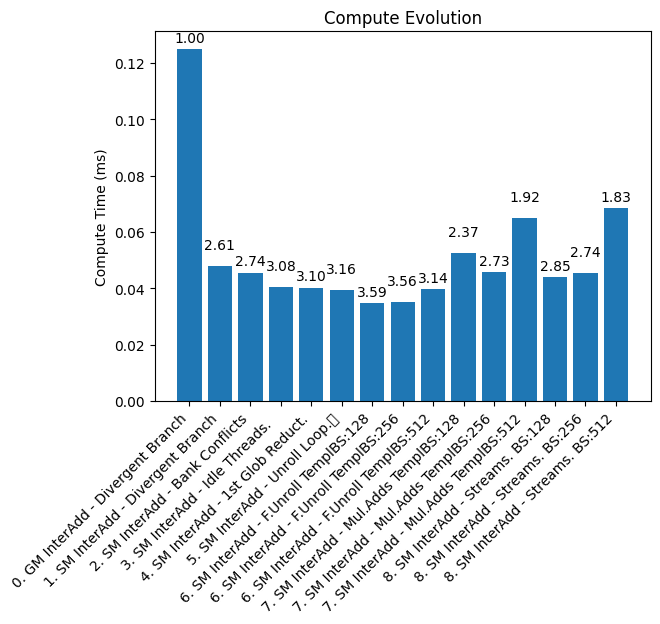

In [44]:
import matplotlib.pyplot as plt

def autolabel(pax, rects, rates):
    for i,rect in enumerate(rects):
        height = rect.get_height()
        if i%2:
          pxytext = (0, 10)  # 3 points vertical offset
        else:
          pxytext = (0, 3)  # 3 points vertical offset

        pax.annotate('{:.2f}'.format(rates[i]),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext = pxytext,
                    textcoords="offset points",
                    ha='center', va='bottom')

fig, ax = plt.subplots()

max_val=max(computes)
print(computes)
rates = [max_val/item for item in computes]
print(rates)
rects1=ax.bar(labels,computes)
autolabel(ax,rects1,rates)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Compute Time (ms)')
ax.set_title('Compute Evolution')
# plt.show() # Comment out the plot to avoid LiveError

# Helion
[Helion](https://github.com/pytorch/helion) is a Python-embedded domain-specific language (DSL) for authoring machine learning kernels, designed to compile down to [Triton](https://github.com/triton-lang/triton), a performant backend for programming GPUs and other devices.

On the other hand, [Triton](https://github.com/triton-lang/triton) is a language and compiler for writing highly efficient custom Deep-Learning primitives. The aim of Triton is to provide an open-source environment to write fast code at higher productivity than CUDA, but also with higher flexibility than other existing DSLs.

In [24]:
%pip install helion

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.6/283.6 kB 25.1 MB/s eta 0:00:00


In [45]:
import torch, helion, helion.language as hl

@helion.kernel(config=helion.Config(block_sizes=[4096, 1], indexing=['block_ptr', 'block_ptr'], load_eviction_policies=['last'], num_stages=7, num_warps=16, pid_type='flat', range_flattens=[None, False], range_multi_buffers=[None, True], range_num_stages=[0, 0], range_unroll_factors=[0, 4], range_warp_specializes=[]), static_shapes=True)
def reduction_sum_helion_helper2(torch_input_data:torch.Tensor, show:bool=False):

  m,n = torch_input_data.size()
  out = torch.empty([m], dtype=torch_input_data.dtype, device=torch_input_data.device)

  block_size_n = hl.register_block_size(n)

  for tile_m in hl.tile(m):
      acc = hl.zeros([tile_m, block_size_n], dtype=torch_input_data.dtype)
      for tile_n in hl.tile(n, block_size=block_size_n): #Reduction loop
        acc += torch_input_data[tile_m,tile_n]
      out[tile_m] =  acc.sum(-1)

  return out


def reduction_sum_helion2(input_data, show:bool=False):
  print(sum(input_data))
  torch_input_data=torch.from_numpy(input_data).to("cuda")
  torch_input_data=torch_input_data.unsqueeze(0) # Add a new dim at the left. Make the array 1xlength_array(input_data)
  print(f"Torch Dim0 {torch_input_data.size(dim=0)} ")

  print(torch.sum(torch_input_data))
  start = time.time()
  partial = reduction_sum_helion_helper2(torch_input_data)
  final_sum=torch.sum(partial)
  end = time.time()
  res_compute = end - start

  print(partial)
  if show:
    print(f"Helion GPU - Final sum: {final_sum:.2f}")

  res_memalloc_time_sec=-1
  res_memalloc_bytes=-1
  res_h2d_time=-1
  res_h2d_bytes=-1
  res_dth_time=-1
  res_dth_bytes=-1

  return ("X. Helion\t",res_memalloc_time_sec, res_memalloc_bytes, res_h2d_time, res_h2d_bytes, res_compute, res_dth_time, res_dth_bytes)

In [47]:
helion_time2=reduction_sum_helion2(input_data,False)
texto,res_memalloc_time_sec, res_memalloc_bytes, res_h2d_time, res_h2d_bytes, res_compute, res_dth_time, res_dth_bytes = helion_time2
print(helion_time2)
print(f"Strategy: {texto} Total time: {(res_compute*1000):.5f} ms")

-253.55841
Torch Dim0 1 
tensor(-253.5556, device='cuda:0')
tensor([-253.5558], device='cuda:0')
('X. Helion\t', -1, -1, -1, -1, 0.00022935867309570312, -1, -1)
Strategy: X. Helion	 Total time: 0.22936 ms


# Comparison Analysis: Total Time

In [48]:
import pandas as pd

labels.append("Helion")
total_times.append(res_compute*1000)
totalmax_val=max(total_times)
totalrates = [totalmax_val/item for item in total_times]

simdata = list(zip(labels,total_times,totalrates))
datatable = pd.DataFrame(simdata, columns=['Approach', 'Total_time','Rate'])
print(datatable)


                                 Approach  Total_time       Rate
0       0. GM InterAdd - Divergent Branch    3.916979   1.000000
1       1. SM InterAdd - Divergent Branch    1.804829   2.170277
2         2. SM InterAdd - Bank Conflicts    1.379490   2.839440
3        3. SM InterAdd - Idle Threads.      1.314640   2.979507
4       4. SM InterAdd - 1st Glob Reduct.    1.275778   3.070267
5         5. SM InterAdd - Unroll Loop.\t    1.314163   2.980588
6   6. SM InterAdd - F.Unroll TemplBS:128    1.195669   3.275972
7   6. SM InterAdd - F.Unroll TemplBS:256    1.241207   3.155782
8   6. SM InterAdd - F.Unroll TemplBS:512    1.260281   3.108021
9   7. SM InterAdd - Mul.Adds TemplBS:128    1.272440   3.078321
10  7. SM InterAdd - Mul.Adds TemplBS:256    1.293421   3.028387
11  7. SM InterAdd - Mul.Adds TemplBS:512    1.199722   3.264905
12       8. SM InterAdd - Streams. BS:128    1.271725   3.080052
13       8. SM InterAdd - Streams. BS:256    1.243591   3.149732
14       8. SM InterAdd -

In [82]:

def autolabel_minmax(pax, rects, ptimes):
    pmin = min(ptimes)
    pmax = max(ptimes)

    for i,rect in enumerate(rects):
      if ptimes[i] in [pmin,pmax]:
        height = rect.get_height()
        pax.annotate(f"{ptimes[i]:.2f} ms",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext = (0,3),
                    textcoords="offset points",
                    color = "black",
                    ha='center', va='bottom')

/tmp/ipython-input-2188338261.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipython-input-2188338261.py:31: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig("kernel_optimization_fig01.pdf", bbox_inches='tight')
/tmp/ipython-input-2188338261.py:31: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig("kernel_optimization_fig01.pdf", bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


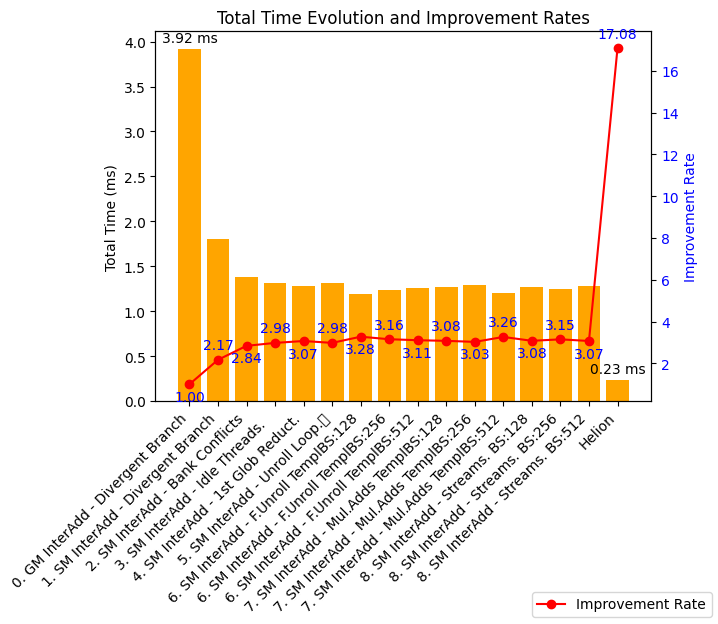

In [93]:
fig1, ax1 = plt.subplots()

# Plot the bar
rects1_total=ax1.bar(datatable["Approach"],datatable["Total_time"], color="orange")
autolabel_minmax(ax1, rects1_total, datatable["Total_time"])
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.set_ylabel('Total Time (ms)')

# Secondary axes object
ax2 = ax1.twinx()
line_total=ax2.plot(datatable["Approach"],datatable["Rate"], color='red', marker='o', label= 'Improvement Rate')

for i,prate in enumerate(datatable["Rate"]):
  offload = None
  if i%2:
    offload = 0.5
  else:
    offload = - 0.8

  plt.annotate(f"{prate:.2f}",
               xy = (i,prate),
               xytext = (i , prate + offload),
               color = "blue",
               ha='center')

ax2.set_ylabel('Improvement Rate', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Total Time Evolution and Improvement Rates')
fig1.legend(loc="lower right")
plt.savefig("kernel_optimization_fig01.pdf", bbox_inches='tight')
plt.show()

In [89]:
def make_pretty(styler):
    styler.set_caption("GPU Kernel Optimizations")
    styler.format_index(lambda v: v)
    styler.background_gradient(axis=None, \
                               subset=["Total_time"], \
                               vmin=min(datatable["Total_time"]), \
                               vmax=max(datatable["Total_time"]), \
                               cmap="YlOrRd")
    styler.background_gradient(axis=None, \
                            subset=["Rate"], \
                            vmin=min(datatable["Rate"]), \
                            vmax=max(datatable["Rate"]), \
                            cmap="YlGnBu")

    return styler

datatable.style.pipe(make_pretty)

,Approach,Total_time,Rate
0,0. GM InterAdd - Divergent Branch,3.916979,1.000000
1,1. SM InterAdd - Divergent Branch,1.804829,2.170277
2,2. SM InterAdd - Bank Conflicts,1.379490,2.839440
3,3. SM InterAdd - Idle Threads.,1.314640,2.979507
4,4. SM InterAdd - 1st Glob Reduct.,1.275778,3.070267
5,5. SM InterAdd - Unroll Loop.,1.314163,2.980588
6,6. SM InterAdd - F.Unroll TemplBS:128,1.195669,3.275972
7,6. SM InterAdd - F.Unroll TemplBS:256,1.241207,3.155782
8,6. SM InterAdd - F.Unroll TemplBS:512,1.260281,3.108021
9,7. SM InterAdd - Mul.Adds TemplBS:128,1.272440,3.078321


# References & Resources
- Harris, Mark. "Optimizing Parallel Reduction in CUDA". NVidia Developer Technology. [Link](https://developer.download.nvidia.com/assets/cuda/files/reduction.pdf)
- [Nsight Systems](https://developer.nvidia.com/nsight-systems). NVIDIA Nsight™ Systems is a system-wide performance analysis tool designed to visualize an application’s algorithms, identify the largest opportunities to optimize, and tune to scale efficiently across any quantity or size of CPUs and GPUs, from large servers to our smallest systems-on-a-chip (SoCs)
- [Nsight Compute](https://developer.nvidia.com/nsight-compute). It is an interactive profiler for CUDA® and NVIDIA OptiX™ that provides detailed performance metrics and API debugging via a user interface and command-line tool.  
- [PyCUDA](https://github.com/inducer/pycuda). It lets you access Nvidia’s CUDA parallel computation API from Python.
- [Pytorch Helion](https://github.com/pytorch/helion). A Python-embedded DSL that makes it easy to write fast, scalable ML kernels with minimal boilerplate.
- [Triton](https://github.com/triton-lang/triton). A language and compiler for writing highly efficient custom Deep-Learning primitives
